# Cognitive Modelling - Tutorial 1 - Part 1
Anne Urai, 2024
Thanks to Alexandre Hyafil, BAMB 2024

# Introduction

<font color='blue'>
In this tutorial, we will cover all the steps involved in modelling behavioral data, from formalizing your hypotheses into a computational model to comparing which model is best supported by the data, using a toy example from a sensory discrimination task. The idea is to map all the types of analyses we may want to perform on behavioral data, before we address in the following days how to perform these analyses for more complex models. More specifically we will cover

- **Model definition**: from box diagram to a statistical description
- **Model simulation**: to understand how the model behaves
- **Model estimation**: fitting model parameters to a behavioral dataset, and assessing the uncertainty about these parameter estimates
- **Model validation**: checking whether a fitted model reproduces the key qualitative features of the dataset
- **Model comparison**: comparing which model better accounts for experimental data
- **Model and parameter recovery**: estimating how well we can estimate model parameters or discriminate between models using a particular behavioral paradigm

In this first part of the tutorial, we will cover model definition, simulation and estimation.

Our behavioral dataset corresponds to a standard two-alternative forced-choice task, where on each trial subjects have to report on the direction of motion of a stimulus with a binary response (left or right). The stimulus strength (or stimulus evidence) is varied across trial. Crucially, in a random subset of trials, brain area X is deactivated (through optogenetics/TMS), leading to a decrease in task performance. Our data is thus composed of one dependent variable (choice $r$, binary, say L/R) and two dependent variables:
- stimulus evidence $s$ (signed, distributed between 9 values)
- condition $c$ (binary, 'default' or 'manipulation')

Here's the question we want to address with our modelling exercice: **is the deactivation affecting stimulus processing or purely decision-making abilities?** In the latter case, deactivating brain area X would not cause any change in stimulus processing, but would promote random responses unrelated to the sensory percept (i.e. 'lapses') in a subset of trials.</font>

## Summary statistics: the psychometric curve
Before starting to define our models, we need to specify what characteristics of the experimental data we expect them to capture. This often corresponds to summary statistics, i.e. the average value of the behavioral variable in different sets of trials (different experimental conditions). In the case of sensory tasks with binary choices, we usually extract the **psychometric curve**, corresponding to the proportion of rightward choices as a function of stimulus evidence. We plot the psychometric curve below, separately for control trials and deactivation trials. This change of the relationship between stimulus and choice is precisely what we expect our model to capture.

In [ ]:
# Import relevant libraries
import numpy as np  # for numerical operations
import pandas as pd  # for handling data structures
import matplotlib.pyplot as plt  # for plotting graphs
from scipy.stats import norm  # for statistical distributions
import scipy.optimize as optimize  # for optimization tasks
import ipywidgets as widgets  # for interactive widgets in Jupyter Notebooks

In [ ]:
# Load the experimental dataset
# The dataset contains the behavioral data from the two-alternative forced-choice task.
df_exp = pd.read_csv("https://raw.githubusercontent.com/bambschool/BAMB2023/main/1-modeling_101/dataset_tutorial1.csv?token=GHSAT0AAAAAACFH2I2TUEKMMHZMREHILHOUZFXCWCA")
df_exp.head()  # display the first few rows to check the data structure

,Unnamed: 0,stimulus,condition,response
0,0,0.0,manipulation,0
1,1,-2.0,manipulation,0
2,2,3.0,control,1
3,3,2.0,control,1
4,4,1.0,control,1


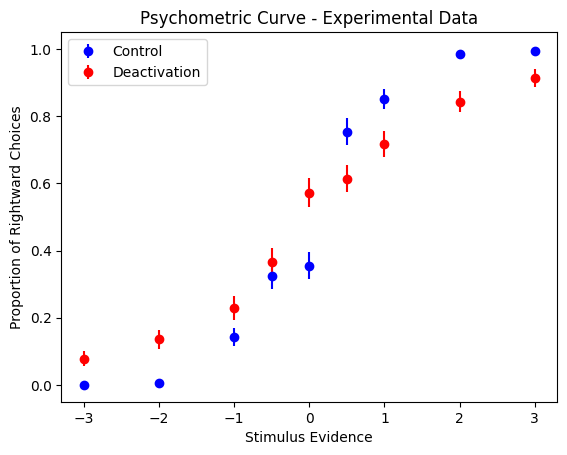

In [ ]:
# Define a function to plot psychometric curves for control and manipulation trials
def plot_data_psychometric(df):
    """
    Plots the psychometric function separately for control and manipulation trials.

    Args:
       df (DataFrame): The experimental dataset with 'stimulus', 'response', and 'condition' columns.
    """
    # Plot psychometric curve for control trials
    mask = df.condition == 'control'  # filter for control trials
    df[mask].groupby('stimulus').response.agg(('mean', 'sem')).plot(
        yerr='sem', fmt='bo', ax=plt.gca(), legend=False
    )  # 'bo' means blue circles for control

    # Plot psychometric curve for manipulation trials
    mask = df.condition == 'manipulation'  # filter for manipulation trials
    df[mask].groupby('stimulus').response.agg(('mean', 'sem')).plot(
        yerr='sem', fmt='ro', ax=plt.gca(), legend=False
    )  # 'ro' means red circles for manipulation

    # Add labels and title
    plt.legend(('Control', 'Deactivation'))  # legend differentiates trial types
    plt.xlabel('Stimulus Evidence')  # X-axis label
    plt.ylabel('Proportion of Rightward Choices')  # Y-axis label
    plt.title('Psychometric Curve - Experimental Data')  # Title

# Plot the psychometric curve for the experimental dataset
plot_data_psychometric(df_exp)

# PART I

In this first part of the tutorial, we will cover **three modelling steps: model definition, model simulations and model estimation**.

# 1. Model definition
<font color='blue'>
We want to define two models, where each model embodies one of the two hypotheses:
- **model A**: the manipulation affects stimulus processing
- **model B**: the manipulation leads to a certain proportion of lapses

Both of these models should take the stimulus evidence and experimental condition (*manipulation* vs. *control*) as input and output the binary choice.
We will follow two successive steps in order to derive a complete statistical description for each of these models.


## 1.1 Box diagram description

First, for each of the two models, draw a box diagram describing how responses are produced and how the experimental manipulation interferes with this production, according to that model. Each diagram should feature boxes describing the causal interaction between the dependent and independent variables (the *observed variables*), and possibly other non-measured variables (the *unobserved variables* or *latent variables*). (Following conventions for Probabilistic Graphical Models, we can colour the observed variable in grey, and leave boxes for latent variables in white).
</font>

What other variables could we introduce?

### Other variables





Response time, if we measure response time this can give us new insights

Expectation, prior expectations about the stimulus might bias the perceptual process for instance if the answer was 'left' three times in a row, the user might have a bias

## 1.2 Statistical model: signal detection theory

Now, in order to be fitted to actual data, we need a **statistical model of behavior**, whereby the modelled behavior (here binary choices) is a stochastic variable that depends on our dependent variables. Here, because the output is binary, each statistical model is described by an equation linking the probability for the binary response (say rightwards responses) as a function of the dependent variables (stimulus and manupulation). To do so, we need to formalize each model one step further by expliciting in our box diagram how each variable in a box is computed from the value of the other variables (through a deterministic or probabilistic relationship to the variables that influence it).

We will use signal-detection theory (SDT) to turn each diagram into a statistical description. In SDT, the perceived stimulus evidence (or percept) is simply the value of the true stimulus evidence (set by the experimenter) corrupted by some gaussian noise:
$\hat s = s + \epsilon$ where $\epsilon$ is gaussian noise of variance $\sigma^2$.
The decision is taken from the position of $\hat s$ w.r.t a threshold $T$. As the noise variance goes larger, the psychometric curve gets shallower and the accuracy of the model deteriorates.

In model A, we assume different noise levels in the two conditions ($\sigma^2_d$ and $\sigma^2_m$), corresponding to different precisions of sensory encoding.
In model B, we assume that the noise variance is not affected by the manipulation. However, in deactivation trials, with a probability $\lambda$, the decision is not based on the stimulus but randomly drawn (with probability $q$ giving response R, probability $1-q$ giving response L).

We now see the **parameter set $\theta$** for each model:
- $T$, $\sigma^2_d$ and $\sigma^2_m$ in model A
- $T$, $\sigma^2_d$, $\lambda$ and $q$ in model B

To simplify things, we will assume no particular bias between L and R responses, so $T=0$ and $q=0.5$. Note that in this case both models have only two free parameters, there are thus equated in terms of complexity.

We will focus on model B for the sake of time. Adapting the analyses for model A is left as optional.

# PART I - 2. Model simulations

## 2.1 Simulate

Create a function that simulates models B. The function should take a list of stimulus and experimental conditions as input, and use the stochastic equations defined above to determine a simulated choice for each corresponding trial.

In [ ]:
# Define a function to simulate Model B (proportion of lapses due to manipulation)
def simulate_modelB(s, c, sigma_d=1, Lambda=0.2, T=0, q=0.5):
    """
    Simulates responses based on Model B, where manipulation leads to lapses.

    Args:
        s (array-like): Array of stimulus evidence values for each trial.
        c (array-like): Array of conditions (1 = manipulation, 0 = control) for each trial.
        sigma_d (float): Variance of the sensory noise.
        Lambda (float): Probability of lapse occurring in manipulation trials.
        T (float): Decision threshold (assumed to be 0).
        q (float): Probability of choosing rightward response in lapse trials (assumed to be 0.5).

    Returns:
        array: Simulated binary choices (1 = rightward, 0 = leftward) for each trial.
    """
    n = len(s)  # Number of trials

    # Generate noisy percepts: true stimulus evidence corrupted by Gaussian noise
    s_hat = s + np.random.normal(0, np.sqrt(sigma_d), size=n)

    # Decision based on the noisy percept: if percept > threshold, choose rightward (1), else leftward (0)
    r_stim = (s_hat > T).astype(int)

    # Determine which trials are lapse trials (random responses occur only in manipulation trials)
    isLapse = (np.random.rand(n) < Lambda) & (c == 1)  # Random response only if manipulation condition

    # Generate random lapse responses: rightward or leftward with probability q or 1-q
    r_lapse = np.random.choice([0, 1], p=[q, 1 - q], size=n)

    # Final response: lapse response if it's a lapse trial, otherwise use stimulus-based response
    r = np.where(isLapse, r_lapse, r_stim)

    return r


Use the function above to simulate model B (with model parameters defined below) on the same set of the trials as the experimental dataset.
(Note: it is important to compare simulations with the exact same set of trials as the original dataset to facilitate comparison)

In [ ]:
# Define parameters for Model B
T = 0  # Decision threshold
sigma = 1  # Noise in sensory evidence
Lambda = 0.2  # Proportion of lapses in manipulation trials
q = 0.5  # Probability of rightward response in lapse trials

# Extract stimulus evidence and condition from experimental dataset
s = df_exp['stimulus'].values  # Array of stimulus evidence
c = df_exp['condition'].map({'manipulation': 1, 'control': 0}).values  # Convert 'condition' to binary (1 = manipulation)

# Simulate Model B using the same stimulus and condition as the experimental data
r = simulate_modelB(s, c, sigma_d=sigma, Lambda=Lambda, T=T, q=q)

# Create a new DataFrame to store the simulated responses
df_modelB = pd.DataFrame({
    'stimulus': s,
    'condition': c,
    'response': r
})

# Display the first few rows of the simulated data
df_modelB.head()


,stimulus,condition,response
0,0.0,1,0
1,-2.0,1,0
2,3.0,0,1
3,2.0,0,1
4,1.0,0,1


## 2.2 Simulated psychometric curve
Now plot the psychometric curve, separately for each condition, for the data simulated from model B.

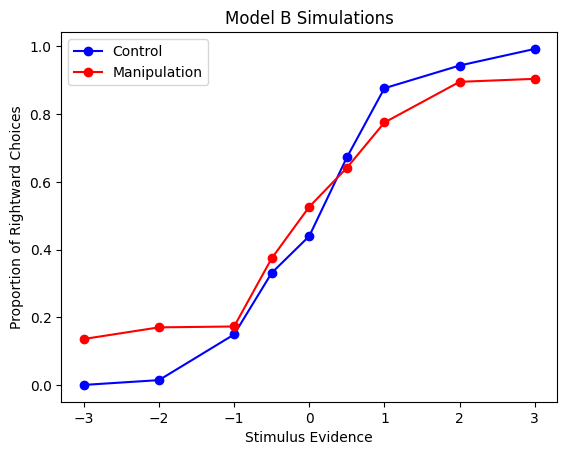

In [ ]:
# Define a function to plot the psychometric curve for Model B
def plot_psychometric_simulation(df):
    """
    Plots the psychometric curve for control and manipulation trials based on simulated data.

    Args:
        df (dataframe): Simulated data.
    """
    # Plot psychometric curve for control trials (condition = 0)
    mask_control = df['condition'] == 0
    df[mask_control].groupby('stimulus').response.mean().plot(marker='o', color='blue', label='Control')

    # Plot psychometric curve for manipulation trials (condition = 1)
    mask_manip = df['condition'] == 1
    df[mask_manip].groupby('stimulus').response.mean().plot(marker='o', color='red', label='Manipulation')

    plt.xlabel('Stimulus Evidence')
    plt.ylabel('Proportion of Rightward Choices')
    plt.legend()
    plt.title('Model B Simulations')

# Plot the psychometric curve for Model B simulations
plot_psychometric_simulation(df_modelB)
plt.show()

(Optional) Repeat the same for model A: define simulation function, use it to simulate data on the set of trials as for the experimental dataset, and plot the corresponding psychometric curves (separately for deactivation and control trials).

In [ ]:
# Define a function to simulate Model A
def simulate_modelA(s, c, sigma_d=1, sigma_m=1.5, T=0):
    """
    Simulates Model A: the manipulation affects sensory noise level.

    Args:
        s (list): Stimulus evidence for each trial.
        c (list): Condition values for each trial (0 for control, 1 for manipulation).
        sigma_d (scalar): Noise variance in control condition.
        sigma_m (scalar): Noise variance in manipulation condition.
        T (scalar): Decision threshold.

    Returns:
        list: Binary choices for each trial (0 = left, 1 = right).
    """
    n = len(s)  # Number of trials

    # Assign noise level based on condition (sigma_d for control, sigma_m for manipulation)
    sigma = np.where(c == 0, sigma_d, sigma_m)

    # Add Gaussian noise to stimulus (true stimulus evidence corrupted by noise)
    s_hat = s + np.random.normal(0, np.sqrt(sigma), size=n)

    # Binary decision: 1 if noisy stimulus is above threshold, 0 otherwise
    r = (s_hat > T).astype(int)
    return r

In [ ]:
# Simulate Model A with given parameters
sigma_d = 1  # Sensory noise in control condition
sigma_m = 1.5  # Sensory noise in manipulation condition
T = 0  # Decision threshold

# Simulate Model A using the extracted conditions and stimulus
r = simulate_modelA(s, c, sigma_d=sigma_d, sigma_m=sigma_m, T=T)

# Create a DataFrame for the simulated data from Model A
df_modelA = pd.DataFrame({'stimulus': s, 'condition': c, 'response': r})

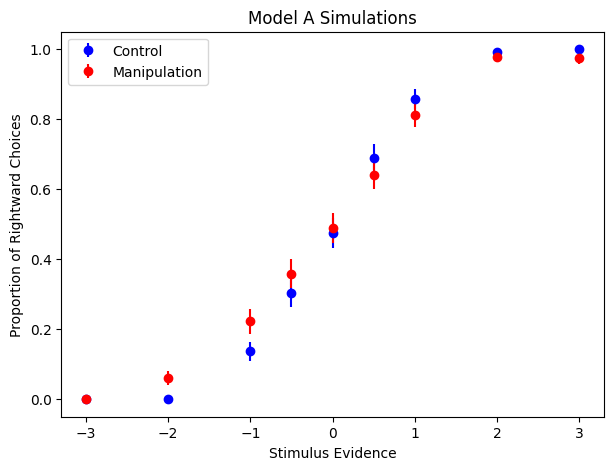

In [ ]:
# Define a function to plot the psychometric curve for Model A
def plot_psychometric_curve(df, title):
    """
    Plots the psychometric curve for control and manipulation trials based on simulated data.

    Args:
        df (dataframe): Simulated data.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(7, 5))

    # Plot psychometric curve for control trials (condition = 0)
    mask_control = df['condition'] == 0
    df[mask_control].groupby('stimulus').response.agg(['mean', 'sem']).plot(
        yerr='sem', fmt='bo', ax=plt.gca(), legend=False)

    # Plot psychometric curve for manipulation trials (condition = 1)
    mask_manip = df['condition'] == 1
    df[mask_manip].groupby('stimulus').response.agg(['mean', 'sem']).plot(
        yerr='sem', fmt='ro', ax=plt.gca(), legend=False)

    plt.title(title)
    plt.xlabel('Stimulus Evidence')
    plt.ylabel('Proportion of Rightward Choices')
    plt.legend(['Control', 'Manipulation'])

# Plot the psychometric curve for Model A simulations
plot_psychometric_curve(df_modelA, 'Model A Simulations')
plt.show()

Can you already visualize a difference in the behavior of the two models?

Yes, clearly the manipulation curve in model A is steeper than in model B

# PART I - 3. Model estimation

We are lucky that in both models we can formulate analytically the statistical link between the observed variable (response) and the conditions.
In simple signal detection theory, $p(r=1|s) = \int_{\hat s} p(r=1|\hat s)p(\hat s|s)d\hat s = \int_{\hat s>T} \mathcal N(\hat s;s,\sigma^2)d\hat s=\Phi( \frac{s-T}{\sigma})$ where $\Phi$ is the cumulative standard normal function.

So for model B (in deactivation trials): $p_B(r=1|s) = (1-\lambda)\Phi( \frac{s}{\sigma}) + \lambda/2$

## 3.1 Naive fitting

A naive fitting procedure consists in adjusting manually the parameters in each model to try to visually match the experimental and theoretical psychometric curves. Here we just adjust the parameters by hand so that the predicted value captures the summary statistics qualitatively.
To do so, first, define a function that computes the probability of a rightward choice according to model B as a function of stimulus evidence and experimental condition. Then define another function which uses this function to plot the theoretical psychometric curves according to model B, now at all continuous valus of stimulus evidence between -3 and 3 (and not just the 9 discrete values explored in the dataset). One of the benefit of using a statistical model is to draw predictions for experimental conditions not seen in the original dataset.

In [ ]:
# Probability of rightward choices according to Model B
def p_modelB(s, c, sigma_d, Lambda):
    """
    Computes the probability of rightward choices according to model B.

    Args:
        s (list): Sensory evidence for each trial.
        c (list): Experimental condition for each trial.
        sigma_d (float): Sensory noise.
        Lambda (float): Lapse probability.

    Returns:
        np.array: Probability of rightward choice for each trial.
    """
    s = np.array(s)
    c = np.array(c)

    # Rightward choice probability for control
    p_ctrl = norm.cdf(s / sigma_d)

    # Rightward choice probability for manipulation (deactivation)
    p_manip = (1 - Lambda) * norm.cdf(s / sigma_d) + Lambda / 2

    # Return probability for control or manipulation condition
    p = np.where(c == 'control', p_ctrl, p_manip)
    return p

# Plot psychometric curve based on model predictions
def plot_model(p_model):
    """
    Plots the psychometric curve according to the given model.

    Args:
        p_model (function): Computes the probability of rightward choices according to the model.
    """
    s_linspace = np.linspace(-3, 3, 100)  # Continuous stimulus values

    # Calculate probabilities for control and manipulation conditions
    p_standard = p_model(s_linspace, 'control')
    p_manipulation = p_model(s_linspace, 'manipulation')

    # Plot the fitted psychometric function
    plt.plot(s_linspace, p_standard, 'b', label="Control")
    plt.plot(s_linspace, p_manipulation, 'r', label="Manipulation")
    plt.ylabel('p(rightward)')
    plt.xlabel('Stimulus Evidence')
    plt.legend()


Now use the widget below to adjust parameters to yield the best possible fit between experimental and theoretical psychometric curves. Is the fit good enough?

In [ ]:
@widgets.interact(
    sigma_hat=widgets.FloatSlider(1.0, min=0.0, max=2.0),  # Sensory noise
    Lambda_hat=widgets.FloatSlider(0.5, min=0.0, max=1.0))  # Lapse probability
def plot_data_estimate(sigma_hat, Lambda_hat):

    # Create an anonymous function to calculate p_modelB with the adjusted parameters
    p_modelB_fun = lambda s, c: p_modelB(s, c, sigma_d=sigma_hat, Lambda=Lambda_hat)

    # Plot model predictions
    plot_model(p_modelB_fun)

    # Add real data points (function plot_data_psychometric should be defined)
    #plot_data_psychometric(df_exp)

    plt.title('Model B');
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='sigma_hat', max=2.0), FloatSlider(value=0.5, descrip…

(Optional) Repeat the same for model A.

In [ ]:
# Probability of rightward choices according to Model A
def p_modelA(s, c, sigma_d, sigma_m):
    """
    Computes the probability of rightward choices according to model A.

    Args:
        s (list): Sensory evidence for each trial.
        c (list): Experimental condition for each trial.
        sigma_d (float): Noise in control condition.
        sigma_m (float): Noise in deactivation condition.

    Returns:
        np.array: Probability of rightward choice for each trial.
    """
    s = np.array(s)
    c = np.array(c)

    # Rightward choice probability for control and manipulation
    p_ctrl = norm.cdf(s / sigma_d)
    p_manip = norm.cdf(s / sigma_m)

    # Return the correct probability based on condition
    p = np.where(c == 'control', p_ctrl, p_manip)
    return p

In [ ]:
@widgets.interact(
    sigma_d_hat=widgets.FloatSlider(1.0, min=0.0, max=2.0),  # Noise in control condition
    sigma_m_hat=widgets.FloatSlider(1.0, min=0.0, max=2.0))  # Noise in manipulation condition
def plot_data_estimate(sigma_d_hat, sigma_m_hat):

    # Plot model predictions with adjusted parameters
    plot_model(lambda s, c: p_modelA(s, c, sigma_d=sigma_d_hat, sigma_m=sigma_m_hat))

    # Add real data points
    #plot_data_psychometric(df_exp)

    plt.title('Model A')
    plt.show()


interactive(children=(FloatSlider(value=1.0, description='sigma_d_hat', max=2.0), FloatSlider(value=1.0, descr…

## 3.2 Likelihood function
Now we will use a more principled approach to parameter estimation by looking for the set of parameters that maximize a given metric, namely the **log-likelihood** of the data. The likelihood function is a function, defined for a given model and dataset, that takes the **parameters as input**.
Complete the following function to compute the log-likelihood of model for a given set of parameters.

In [ ]:
def LogLikelihood_modelB(df, sigma_d, Lambda):
    """
    Computes the log-likelihood of Model B with a given parameter set.

    Args:
        df (DataFrame): Dataset containing trial data (stimulus, condition, response).
        sigma_d (float): Sensory noise.
        Lambda (float): Lapse probability.

    Returns:
        float: Log-likelihood of Model B.
    """
    s = df['stimulus'].values
    c = df['condition'].values
    r = df['response'].values

    # Calculate the probability of rightward choice for each trial using Model B
    p = p_modelB(s, c, sigma_d, Lambda)

    # Compute likelihood for each trial: p if response is rightward, 1-p otherwise
    lh = np.where(r == 1, p, 1 - p)

    # Avoid division by zero
    lh = np.where(lh == 0, np.finfo(float).eps, lh)

    # Calculate the log-likelihood for the dataset
    LLH = np.sum(np.log(lh))

    return LLH

Compute the log-likelihood of model B at the values of the parameters obtained by naive fitting.

In [ ]:
# Naively fitted parameters
sigma_d_hat = 1.0
Lambda_hat = 0.2

# Compute log-likelihood of Model B
llh_B = LogLikelihood_modelB(df_exp, sigma_d_hat, Lambda_hat)
print(f"Log-likelihood of Model B: {llh_B}")


Log-likelihood of Model B: -1037.0948048755777


## 3.3 Maximum likelihood estimation

Now that we have a function of parameters that defines a metric for how well the model accounts for the data, we will look for the parameter space in search for the parameter set that maximizes this metric.
First, plot the value of the LLH as a function of both parameters, as a coloured plot.

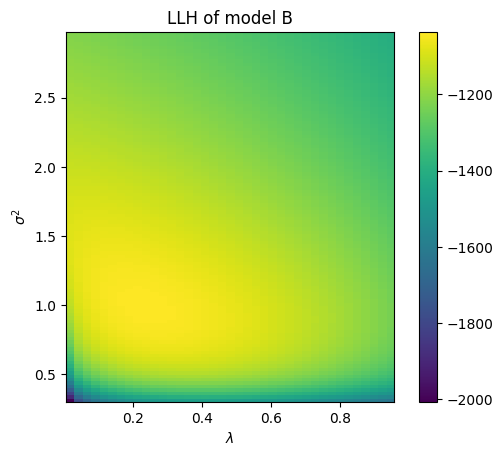

In [ ]:
# Define linearly spaced values of Lambda (lapse rate) and sigma (sensory noise variance)
Lambda = np.arange(0.005, 0.96, 0.025)
sigma = np.arange(0.3, 3.0, 0.025)

# Compute a grid of all possible parameter pairs (Lambda, sigma)
LL, ss = np.meshgrid(Lambda, sigma)

# Initialize an array to store the log-likelihood values for each parameter pair
LLH = np.zeros(LL.shape)

# Loop over each combination of Lambda and sigma and compute log-likelihood for model B
for j in range(LL.shape[0]):
    for k in range(LL.shape[1]):
        LLH[j, k] = LogLikelihood_modelB(df_exp, sigma[j], Lambda[k])

# Function to display the log-likelihood profile as a colored plot (heatmap)
def show_LL(LLH, Lambda, sigma):
    # Flip LLH array to match the plot axes, and set color plot
    im = plt.imshow(np.flipud(LLH), extent=[Lambda[0], Lambda[-1], sigma[0], sigma[-1]])
    plt.gca().set_aspect(0.4)  # Adjust the aspect ratio
    plt.ylabel('$\sigma^2$')    # Label for sigma (variance)
    plt.xlabel('$\lambda$')     # Label for lambda (lapse rate)
    plt.colorbar(im)            # Add a color bar to indicate likelihood scale

# Plot the log-likelihood profile
show_LL(LLH, Lambda, sigma)
plt.title('LLH of model B')
plt.show()

Finally, we can identify the maximum-likelihood parameters by using an optimization algorithm over the LLH function. Because most optimization tools are defined for minimization rather than maximization, we will actually minimize the negative Log-Likelihood (which is equivalent to maximize the LLH).

In [ ]:
# Define the objective function for optimization (negative log-likelihood of model B)
def neg_llh_modelB(pp, df):
    """
    Computes the negative log-likelihood for model B.

    Args:
        pp (list): set of parameters [sigma_d, Lambda]
        df (dataframe): dataset

    Returns:
        scalar: negative log-likelihood (to be minimized)
    """
    sigma_d, Lambda = pp
    llh_b = -LogLikelihood_modelB(df, sigma_d, Lambda)  # Negative log-likelihood
    return llh_b

# Define the bounds for each parameter (to restrict the search space)
bounds = [(0.1, 10), (0.01, 1)]  # sigma_d between 0.1 and 10, Lambda between 0.01 and 1

# Initial guess for the parameter set [sigma_d, Lambda]
x0 = [0.75, 0.5]

# Perform the optimization to minimize the negative log-likelihood
result = optimize.minimize(neg_llh_modelB, x0=x0, args=(df_exp), bounds=bounds)

# Retrieve the optimized parameters (MLE estimates)
sigma_hat, Lambda_hat = result.x

# Print the maximum likelihood estimates
print("sigma_hat^2 =", sigma_hat)
print("Lambda_hat =", Lambda_hat)

sigma_hat^2 = 0.9770946774223463
Lambda_hat = 0.22677753635308115


Add the maximum likelihood parameters as a red dot on the LLH profile.

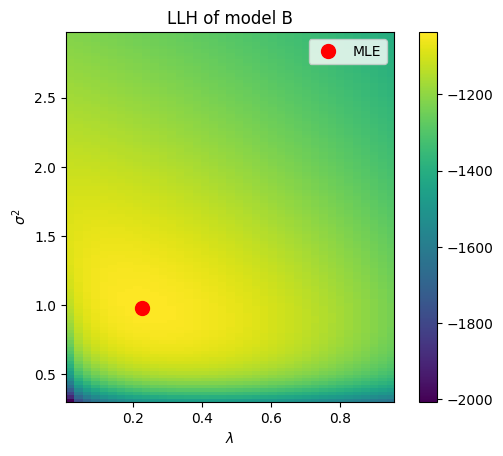

In [ ]:
# Plot the LLH profile again and add the MLE parameters as a red dot
show_LL(LLH, Lambda, sigma)
plt.plot(Lambda_hat, sigma_hat, 'ro', markersize=10, label='MLE')  # MLE shown as a red dot
plt.legend()
plt.title('LLH of model B')
plt.show()

(Optional) Repeat maximum likelihood estimation, now for model A.

In [ ]:
# Define log-likelihood computation for model A
def LogLikelihood_modelA(df, sigma_d, sigma_m):
    """
    Computes the log-likelihood of model A for a given set of parameters.

    Args:
        df (dataframe): dataset
        sigma_d (scalar): variance of sensory noise in control trials
        sigma_m (scalar): variance of sensory noise in deactivation trials

    Returns:
        scalar: log-likelihood value
    """
    # Extract stimulus, condition, and response from the dataset
    s = df['stimulus'].values
    c = df['condition'].values
    r = df['response'].values

    # Use sigma_d for control trials and sigma_m for manipulated trials
    sigma = np.where(c == 0, sigma_d, sigma_m)

    # Compute the probability of a rightward choice based on sensory evidence
    p = norm.cdf(s / sigma)

    # Compute the likelihood for each trial (p if response is rightward, 1 - p otherwise)
    lh = np.where(r == 1, p, 1 - p)

    # Avoid division by zero by replacing zero likelihoods with a small value
    lh = np.where(lh == 0, np.finfo(float).eps, lh)

    # Compute the log-likelihood by summing the log of the likelihoods
    LLH = np.sum(np.log(lh))

    return LLH


In [ ]:
# Define the objective function (negative log-likelihood of model A)
def neg_llh_modelA(pp, df):
    """
    Computes the negative log-likelihood for model A.

    Args:
        pp (list): set of parameters [sigma_d, sigma_m]
        df (dataframe): dataset

    Returns:
        scalar: negative log-likelihood (to be minimized)
    """
    sigma_d, sigma_m = pp
    llh_a = -LogLikelihood_modelA(df, sigma_d, sigma_m)  # Negative log-likelihood
    return llh_a

# Define the bounds for each parameter (sigma_d and sigma_m)
bounds = [(0.1, 10), (0.1, 10)]  # Both sigma_d and sigma_m between 0.1 and 10

# Initial guess for the parameter set [sigma_d, sigma_m]
x0 = [0.75, 0.5]

# Perform the optimization to minimize the negative log-likelihood
result = optimize.minimize(neg_llh_modelA, x0=x0, args=(df_exp), bounds=bounds)

# Retrieve the optimized parameters (MLE estimates)
sigma_d_hat, sigma_m_hat = result.x

# Print the maximum likelihood estimates
print("sigma_d_hat^2 =", sigma_d_hat)
print("sigma_m_hat^2 =", sigma_m_hat)

sigma_d_hat^2 = 0.75
sigma_m_hat^2 = 1.4655614053547212
